In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import maketab as mt
from torch.utils.data import DataLoader, Dataset

In [11]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def normalize(train_data):
    mins = np.min(train_data, axis=1, keepdims=True)
    maxs = np.max(train_data, axis=1, keepdims=True)
    normalized_train = (train_data - mins) / (maxs - mins)
    params = {'mins': mins, 'maxs': maxs}   
    return normalized_train, params

def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    tleft = 1 - t / max(t)
    return signal, tleft, t

data = load_data('data/5-2-25/')
norm_data, _ = normalize(data)
f_values, g_values, x_values = norm_data
plt.plot(x_values, f_values)
plt.plot(x_values, g_values)
plt.show()

NameError: name 'mt' is not defined

In [6]:
n = 30  # Number of values to predict at a time
input_size = n  # Input is a window of size n
hidden_size = 50  # Number of neurons in the hidden layer
output_size = n  # Output is a window of size n
num_epochs = 200
batch_size = 16

In [7]:
# Convert to PyTorch tensors
f_tensor = torch.tensor(f_values, dtype=torch.float32)
g_tensor = torch.tensor(g_values, dtype=torch.float32)

# Create sliding windows of size n
X = []
Y = []
for i in range(len(f_values) - n):
    X.append(f_tensor[i:i+n])  # Input window of size n
    Y.append(g_tensor[i:i+n])  # Target window of size n

# Stack into tensors
X = torch.stack(X)
Y = torch.stack(Y)

# Create dataset and dataloader
dataset = CustomDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Define the model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Initialize model, loss function, and optimizer
model = MLP(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
for epoch in range(num_epochs):
    for batch_X, batch_Y in dataloader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [50/200], Loss: 0.0568
Epoch [100/200], Loss: 0.0631
Epoch [150/200], Loss: 0.0631
Epoch [200/200], Loss: 0.0552


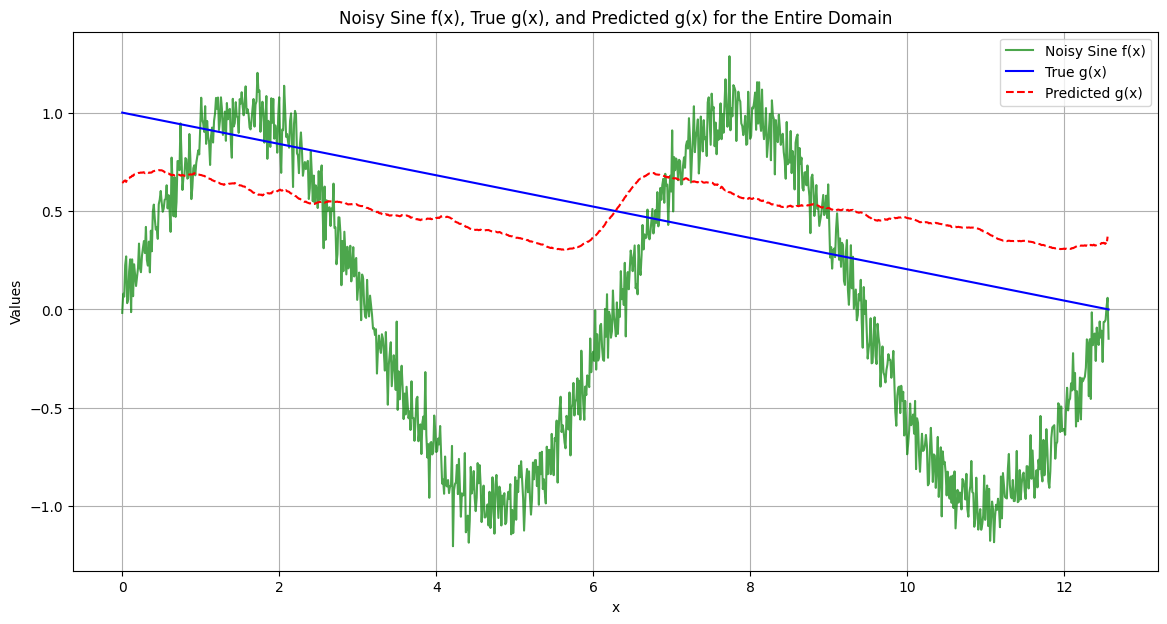

In [10]:
# Predict for all windows
with torch.no_grad():
    predictions = []
    for i in range(X.size(0)):
        window = X[i].unsqueeze(0)  # Get a window of size n
        pred = model(window)  # Predict g(x) for this window
        predictions.append(pred.squeeze())

# Combine predictions
predicted_g_full = torch.cat(predictions)

# Since the windows overlap, we average the predictions for overlapping regions
predicted_g_full_avg = torch.zeros_like(g_tensor)
counts = torch.zeros_like(g_tensor)

for i, pred in enumerate(predictions):
    predicted_g_full_avg[i:i+n] += pred
    counts[i:i+n] += 1

predicted_g_full_avg /= counts  # Average overlapping predictions

# Plot the results
plt.figure(figsize=(14, 7))

# Plot the noisy sine function f(x)
plt.plot(x_values, f_values, label='Noisy Sine f(x)', color='green', linestyle='-', alpha=0.7)

# Plot the true g(x)
plt.plot(x_values, g_values, label='True g(x)', color='blue', linestyle='-')

# Plot the predicted g(x)
plt.plot(x_values, predicted_g_full_avg.numpy(), label='Predicted g(x)', color='red', linestyle='--')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('Values')
plt.legend()
plt.title('Noisy Sine f(x), True g(x), and Predicted g(x) for the Entire Domain')
plt.grid(True)
plt.show()

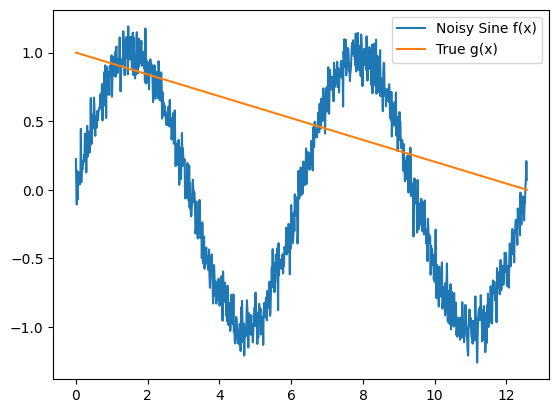

Epoch [50/200], Loss: 0.0587
Epoch [100/200], Loss: 0.0627
Epoch [150/200], Loss: 0.0617
Epoch [200/200], Loss: 0.0539


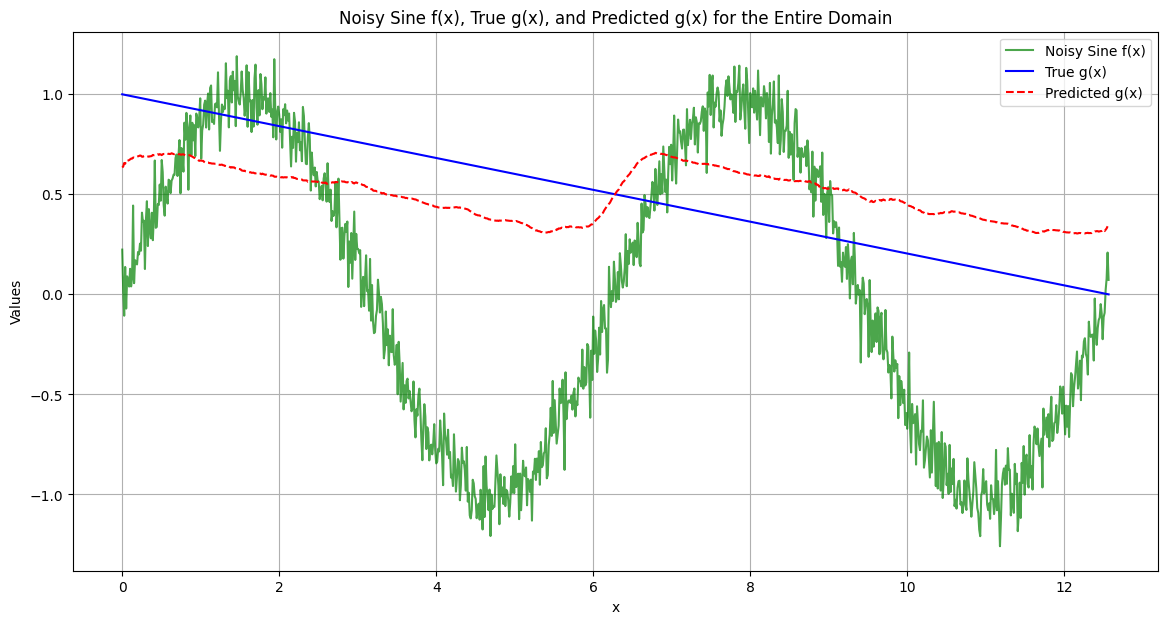

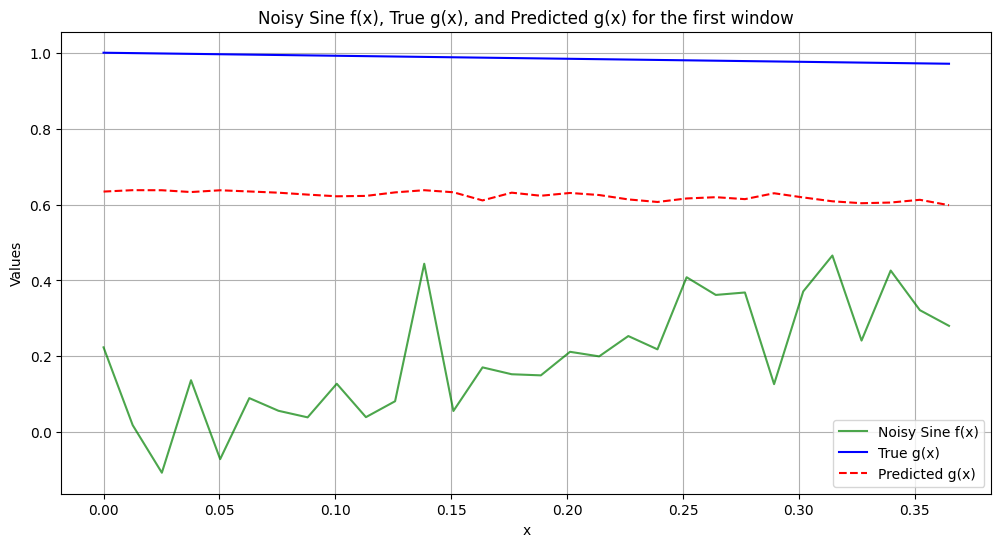

In [1]:
# Test the model
with torch.no_grad():
    test_input = X[0].unsqueeze(0)  # Take the first window as test input
    predicted_g = model(test_input)

# Plot the first window
plt.figure(figsize=(12, 6))

# Plot the noisy sine function f(x)
plt.plot(x_values[:n], f_values[:n], label='Noisy Sine f(x)', color='green', linestyle='-', alpha=0.7)

# Plot the true g(x)
plt.plot(x_values[:n], g_values[:n], label='True g(x)', color='blue', linestyle='-')

# Plot the predicted g(x)
plt.plot(x_values[:n], predicted_g.squeeze().numpy(), label='Predicted g(x)', color='red', linestyle='--')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('Values')
plt.legend()
plt.title('Noisy Sine f(x), True g(x), and Predicted g(x) for the first window')
plt.grid(True)
plt.show()